In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Veri setini yükleme
file_path = '/content/drive/MyDrive/TURKCELL/Thermal-Comfort/ashrae_db2.01.csv'
df = pd.read_csv(file_path)

# Gerekli sütunları seçme
selected_features = ["Sex", "Age", "SET", "Climate", "Season", "Clo", "Met", "Air temperature (C)"]
df = df[selected_features + ["Thermal preference"]]

# Kategorik verileri sayısal formata dönüştürme
label_encoders = {}
for column in ["Sex", "Climate", "Season"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Eksik değerleri temizleme
df = df.dropna()

# Veri setini bağımsız ve bağımlı değişkenlere ayırma
X = df.drop(columns=["Thermal preference"])
y = df["Thermal preference"]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluşturma ve eğitme
model = LGBMClassifier()
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma
y_pred = model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Sonuçları ekrana yazdırma
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

<ipython-input-16-4299c9d8ce08>:11: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 18482, number of used features: 8
[LightGBM] [Info] Start training from score -1.254008
[LightGBM] [Info] Start training from score -0.608528
[LightGBM] [Info] Start training from score -1.769077
Accuracy: 0.67
Precision: 0.69
Recall: 0.67
F1 Score: 0.65

Confusion Matrix:
[[ 682  632   12]
 [ 244 2170   74]
 [  32  525  250]]


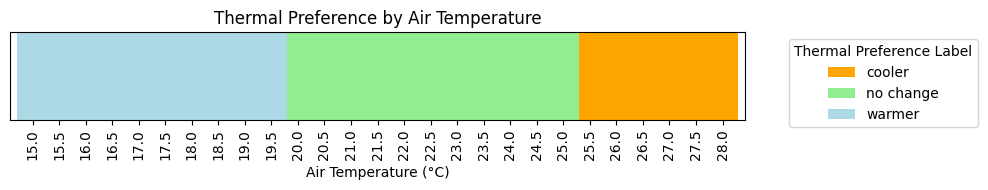

In [ ]:
# Define the customer profile and temperature range
customer_profile = {
    #"Name": "Ayşe",
    "Sex": label_encoders["Sex"].transform(["Female"])[0],
    "Age": 30,
    "SET": 22,
    "Climate": label_encoders["Climate"].transform(["Humid subtropical"])[0],
    "Season": label_encoders["Season"].transform(["Summer"])[0],
    "Clo": 0.5,
    "Met": 1.2
}

# Create temperature range
temperature_range = np.arange(15, 28.5, 0.5)
predictions = []

for temp in temperature_range:
    customer_data = customer_profile.copy()
    customer_data["Air temperature (C)"] = temp
    customer_df = pd.DataFrame([customer_data])
    pred = model.predict(customer_df)
    predictions.append(pred[0])

# Convert predictions to DataFrame
df_mt2 = pd.DataFrame({
    "Air temperature (C)": temperature_range,
    "Thermal Preference Label": predictions
})

# Calculate counts for each temperature and preference
temperature_preferences = df_mt2.groupby(['Air temperature (C)', 'Thermal Preference Label']).size().reset_index(name='Counts')
temperature_preferences['Total Counts'] = temperature_preferences.groupby('Air temperature (C)')['Counts'].transform('sum')

# Calculate proportions for each category
temperature_preferences['Proportion'] = temperature_preferences['Counts'] / temperature_preferences['Total Counts']

# Create a pivot table for the stacked bar chart
pivot_df = temperature_preferences.pivot(index='Air temperature (C)', columns='Thermal Preference Label', values='Proportion').fillna(0)

# Plot the stacked bar chart
bar_width = 1.2  # Adjust bar width
ax = pivot_df.plot(kind='bar', stacked=True, color=['orange', 'lightgreen', 'lightblue'], figsize=(10, 2), width=bar_width)  # Reduce height

# Hide y-axis and shorten bars
plt.ylim(0, 0.5)  # Limit the y-axis to make bars shorter
plt.gca().yaxis.set_visible(False)  # Hide the y-axis

plt.xlabel('Air Temperature (°C)')
plt.title('Thermal Preference by Air Temperature')
plt.legend(title='Thermal Preference Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-28-58e92eea42f2>:12: DtypeWarning: Columns (10,11,13,18,19,34,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Model loaded from disk
Accuracy: 0.67
Precision: 0.69
Recall: 0.67
F1 Score: 0.65

Confusion Matrix:
[[ 682  632   12]
 [ 244 2170   74]
 [  32  525  250]]


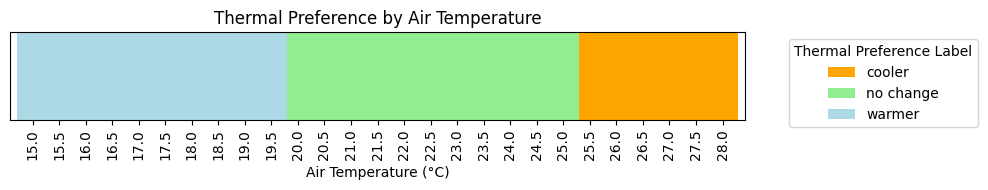

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib  # Importing joblib for saving and loading the model

# Veri setini yükleme
file_path = '/content/drive/MyDrive/TURKCELL/Thermal-Comfort/ashrae_db2.01.csv'
df = pd.read_csv(file_path)

# Gerekli sütunları seçme
selected_features = ["Sex", "Age", "SET", "Climate", "Season", "Clo", "Met", "Air temperature (C)"]
df = df[selected_features + ["Thermal preference"]]

# Kategorik verileri sayısal formata dönüştürme
label_encoders = {}
for column in ["Sex", "Climate", "Season"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# Eksik değerleri temizleme
df = df.dropna()

# Veri setini bağımsız ve bağımlı değişkenlere ayırma
X = df.drop(columns=["Thermal preference"])
y = df["Thermal preference"]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the trained model to a file
model_filename = '/content/drive/MyDrive/TURKCELL/Thermal-Comfort/thermal_preference_model.joblib'

# Load the model from the file
loaded_model = joblib.load(model_filename)
print("Model loaded from disk")

# Test seti üzerinde tahmin yapma
y_pred = loaded_model.predict(X_test)

# Modelin performansını değerlendirme
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Sonuçları ekrana yazdırma
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Tahmin edilecek müşteri profilini ve sıcaklık aralığını belirleme
customer_profile = {
    "Sex": label_encoders["Sex"].transform(["Female"])[0],
    "Age": 30,
    "SET": 22,
    "Climate": label_encoders["Climate"].transform(["Humid subtropical"])[0],
    "Season": label_encoders["Season"].transform(["Summer"])[0],
    "Clo": 0.5,
    "Met": 1.2
}

# Sıcaklık aralığını oluşturma
temperature_range = np.arange(15, 28.5, 0.5)
predictions = []

for temp in temperature_range:
    customer_data = customer_profile.copy()
    customer_data["Air temperature (C)"] = temp
    customer_df = pd.DataFrame([customer_data])
    pred = loaded_model.predict(customer_df)
    predictions.append(pred[0])

# Tahmin sonuçlarını DataFrame'e dönüştürme
df_mt2 = pd.DataFrame({
    "Air temperature (C)": temperature_range,
    "Thermal Preference Label": predictions
})

# Her sıcaklık ve tercih için sayımları hesaplayın
temperature_preferences = df_mt2.groupby(['Air temperature (C)', 'Thermal Preference Label']).size().reset_index(name='Counts')
temperature_preferences['Total Counts'] = temperature_preferences.groupby('Air temperature (C)')['Counts'].transform('sum')

# Her kategori için orantıyı hesaplayın
temperature_preferences['Proportion'] = temperature_preferences['Counts'] / temperature_preferences['Total Counts']

# Pivot tablo oluşturarak stacked bar chart hazırlığı yapın
pivot_df = temperature_preferences.pivot(index='Air temperature (C)', columns='Thermal Preference Label', values='Proportion').fillna(0)

# Stacked Bar Chart çizimi
bar_width = 1.2  # Bar genişliği
ax = pivot_df.plot(kind='bar', stacked=True, color=['orange', 'lightgreen', 'lightblue'], figsize=(10, 2), width=bar_width)  # Reduce height

# Hide y-axis and shorten bars
plt.ylim(0, 0.5)  # Limit the y-axis to make bars shorter
plt.gca().yaxis.set_visible(False)  # Hide the y-axis

plt.xlabel('Air Temperature (°C)')
plt.title('Thermal Preference by Air Temperature')
plt.legend(title='Thermal Preference Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Print the unique encoded values in the Season, Sex, and Climate columns
encoded_seasons = df['Season'].unique()
encoded_sex = df['Sex'].unique()
encoded_climate = df['Climate'].unique()

print("Encoded values in 'Season' column:", encoded_seasons)
print("Encoded values in 'Sex' column:", encoded_sex)
print("Encoded values in 'Climate' column:", encoded_climate)

# Access the LabelEncoder for the 'Season', 'Sex', and 'Climate' columns
season_classes = label_encoders['Season'].classes_
sex_classes = label_encoders['Sex'].classes_
climate_classes = label_encoders['Climate'].classes_

print("\nOriginal categories and their encoded values:")
print("Season:")
for index, season in enumerate(season_classes):
    print(f"  {season}: {index}")

print("\nSex:")
for index, sex in enumerate(sex_classes):
    print(f"  {sex}: {index}")

print("\nClimate:")
for index, climate in enumerate(climate_classes):
    print(f"  {climate}: {index}")

Encoded values in 'Season' column: [2 3 1 0]
Encoded values in 'Sex' column: [2 0 1]
Encoded values in 'Climate' column: [ 7 14  4 16  9 11 12 18 10  3]

Original categories and their encoded values:
Season:
  Autumn: 0
  Spring: 1
  Summer: 2
  Winter: 3
  nan: 4

Sex:
  Female: 0
  Male: 1
  nan: 2

Climate:
  Cold semi-arid: 0
  Cool-summer Mediterranean: 1
  Cool-summer mediterranean: 2
  Hot desert: 3
  Hot semi-arid: 4
  Hot-summer Mediterranean: 5
  Hot-summer mediterranean: 6
  Humid subtropical: 7
  Monsoon-influenced hot-summer humid continental: 8
  Monsoon-influenced humid subtropical: 9
  Oceanic: 10
  Subtropical highland: 11
  Temperate oceanic: 12
  Tropical dry savanna: 13
  Tropical monsoon: 14
  Tropical rainforest: 15
  Tropical wet savanna: 16
  Warm-summer Mediterranean: 17
  Warm-summer humid continental: 18
